In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Functions

In [2]:
def plot_ipc_bar(df, title="IPC for Different Prefetchers on different traces", y_max=1.4, xticks_bot_size=20):
    colors = {
        "nopref": "black",
        "spp": "red",
        "bingo": "blue",
        "mlop": "green",
        "pythia": "orange",
        "dspatch": "purple",
        "ppf": "yellow",
    }

    plt.figure(figsize=(18, 6))
    
    traces = df["Trace"].unique()
    
    x_positions = []
    x_labels = []
    
    for i, trace in enumerate(traces):
        subset = df[df["Trace"] == trace]
        x_pos = [i * 8 + j for j in range(len(subset))]
        x_positions.extend(x_pos)
        x_labels.extend(subset["Exp"])
    
        plt.bar(
            x_pos, 
            subset["Core_0_IPC"], 
            color=[colors[exp] for exp in subset["Exp"]], 
            label=trace if i == 0 else ""
        )
    
    plt.xticks(
        [i * 8 + 3 for i in range(len(traces))], 
        traces, 
        rotation=45,
        ha="right",
        fontsize=xticks_bot_size
    )
    
    plt.xlabel("Trace", fontsize=20)
    plt.ylabel("IPC", fontsize=20)
    plt.title(title, fontsize=20)
    
    plt.ylim(0, y_max) 
    
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in colors]
    plt.legend(handles, colors.keys(), title="Prefetcher", loc="upper right", fontsize=14, bbox_to_anchor=(1, 1))
    
    plt.show()

def plot_coverage_bar(df, title="Coverage and Overprediction Againts Baseline LLC Misses", xticks_top_size=20):
    colors = {
        "Covered": "red",
        "Uncovered": "green",
        "Overpredicted": "yellow"
    }
    
    bar_width = 0.4  
    
    experiments = df["Exp"].unique().tolist()
    experiments.remove("nopref") if "nopref" in experiments else None
    df["Trace_Group"] = df["Trace"].apply(lambda x: x.split("_")[0])
    trace_groups = sorted(df["Trace_Group"].unique())  
    
    fig, ax = plt.subplots(figsize=(15, 6))
    x_positions = []
    group_positions = []
    pos = 0
    
    max_value = 0  
    
    for group in trace_groups:
        group_traces = df[df["Trace_Group"] == group]["Trace"].unique()
        
        if len(group_traces) > 0:
            group_positions.append(pos)
    
        for trace in group_traces:
            for exp in experiments:
                subset = df[(df["Trace"] == trace) & (df["Exp"] == exp)]
                if subset.empty:
                    continue
    
                covered = subset["Coverage"].values[0] * 100
                uncovered = subset["Uncovered"].values[0] * 100
                overpredicted = subset["Overprediction"].values[0] * 100
    
                max_value = max(max_value, covered + uncovered + overpredicted)
    
                bottom_stack = 0
                ax.bar(pos, covered, bar_width, color=colors["Covered"])
                bottom_stack += covered
                ax.bar(pos, uncovered, bar_width, color=colors["Uncovered"], edgecolor="black", bottom=bottom_stack)
                bottom_stack += uncovered
                ax.bar(pos, overpredicted, bar_width, color=colors["Overpredicted"], edgecolor="black", bottom=bottom_stack)
    
                ax.text(pos, -10, exp.upper(), fontsize=xticks_top_size, ha="center", va="top", rotation=90)
    
                x_positions.append(pos)
                pos += 1
    
    for group_pos in group_positions:
        ax.axvline(x=group_pos - bar_width, color="black", linewidth=1)
    
    ax.set_xlim(-1, pos)
    
    for group_pos, group_name in zip(group_positions, trace_groups):
        ax.text(group_pos + ((len(experiments) * bar_width) / 2), -120, group_name, fontsize=18, fontweight="bold",
                ha="center", va="top", color="black", rotation=45)
    
    ax.set_xticks(x_positions)  
    ax.set_xticklabels([])
    
    
    y_max = np.ceil((max_value + 10) / 50) * 50
    
    ax.set_ylabel("Fraction of LLC Misses (%)", fontsize=14)
    ax.set_title(title, fontsize=20)
    ax.set_ylim(0, y_max)
    ax.set_yticks(np.arange(0, y_max + 1, 50))
    ax.set_yticklabels([f"{int(y)}%" for y in np.arange(0, y_max + 1, 50)])
    ax.yaxis.grid(True, linestyle="--", alpha=0.7)
    
    handles = [
        plt.Rectangle((0, 0), 1, 1, color=colors["Covered"], label="Covered"),
        plt.Rectangle((0, 0), 1, 1, color=colors["Uncovered"], edgecolor="black", label="Uncovered"),
        plt.Rectangle((0, 0), 1, 1, color=colors["Overpredicted"], edgecolor="black", label="Overpredicted")
    ]
    ax.legend(handles=handles, loc="upper right", fontsize=14)
    
    plt.tight_layout()
    plt.show()

def plot_bar(df, stat_name='load_miss_rate', title='', y_label='', color='blue', xticks_top_size=20):
    bar_width = 0.4  

    experiments = df["Exp"].unique().tolist()
    if "nopref" in experiments:
        experiments.remove("nopref")

    df["Trace_Group"] = df["Trace"].apply(lambda x: x.split("_")[0])
    trace_groups = sorted(df["Trace_Group"].unique())  

    fig, ax = plt.subplots(figsize=(15, 8))
    x_positions = []
    group_positions = []
    pos = 0
    
    max_value = 0  # Track the highest value properly

    for group in trace_groups:
        group_traces = df[df["Trace_Group"] == group]["Trace"].unique()
        
        if len(group_traces) > 0:
            group_positions.append(pos)

        for trace in group_traces:
            for exp in experiments:
                subset = df[(df["Trace"] == trace) & (df["Exp"] == exp)]
                if subset.empty:
                    continue

                stat = subset[stat_name].values[0] * 100
                max_value = max(max_value, stat)  # Corrected max_value update

                ax.bar(pos, stat, bar_width, color=color)
                ax.text(pos, -1, exp.upper(), fontsize=xticks_top_size, ha="center", va="top", rotation=90)

                x_positions.append(pos)
                pos += 1

    for group_pos in group_positions:
        ax.axvline(x=group_pos - bar_width, color="black", linewidth=1)

    ax.set_xlim(-1, pos)

    for group_pos, group_name in zip(group_positions, trace_groups):
        ax.text(group_pos + ((len(experiments) * bar_width) / 2), -24, group_name, fontsize=18, fontweight="bold",
                ha="center", va="top", color="black", rotation=45)

    ax.set_xticks(x_positions)  
    ax.set_xticklabels([])

    # Proper y_max scaling
    y_max = max(np.ceil((max_value + 10) / 10) * 10, 50)  # Adjust scale dynamically
    ax.set_ylim(0, y_max)
    ax.set_yticks(np.arange(0, y_max + 1, 10))  
    ax.set_yticklabels([f"{int(y)}%" for y in np.arange(0, y_max + 1, 10)])

    ax.set_ylabel(y_label, fontsize=20)
    ax.set_title(title, fontsize=20)
    ax.yaxis.grid(True, linestyle="--", alpha=0.7)

    handles = [plt.Rectangle((0, 0), 1, 1, color=color, label=stat_name)]
    ax.legend(handles=handles, loc="upper right")
    
    plt.tight_layout()
    plt.show()

In [3]:
df = pd.read_csv('data/rollup.csv')
df = df[df.Trace!='621.wrf_s-6673B'].reset_index(drop=True)
df['LLC_read_misses'] = df.Core_0_LLC_total_miss - df.Core_0_LLC_RFO_miss - df.Core_0_LLC_writeback_miss
# merge nopref baseline metrics to calculate relative improvement
df = df.merge(df[df.Exp=='nopref'].drop(columns=['Exp', 'Filter']), on='Trace', suffixes=('', '_nopref'))

df['load_miss_rate'] = df.Core_0_LLC_load_miss / df.Core_0_LLC_total_miss
df['RFO_miss_rate'] = df.Core_0_LLC_RFO_miss / df.Core_0_LLC_total_miss
df['writeback_miss_rate'] = df.Core_0_LLC_writeback_miss / df.Core_0_LLC_total_miss
df['IPC_relative_improvement'] = ((df.Core_0_IPC / df.Core_0_IPC_nopref) - 1).round(5) # relative IPC improvement over nopref
df['cache_miss_reduction'] = (df.Core_0_LLC_total_miss - df.Core_0_LLC_total_miss_nopref) / df.Core_0_LLC_total_miss # cache miss reduction over nopref
df['load_to_RFO_miss_ratio'] = df.Core_0_LLC_load_miss / df.Core_0_LLC_RFO_miss
df['Coverage'] = ((df.Core_0_LLC_load_miss_nopref - df.Core_0_LLC_load_miss) / (df.Core_0_LLC_load_miss_nopref + 1)).clip(0, 2)
df['Uncovered'] = (1 - df.Coverage).clip(0, 1)
df['Overprediction'] = ((df.LLC_read_misses - df.LLC_read_misses_nopref) / (df.LLC_read_misses_nopref + 1)).clip(0, 3)

In [4]:
# split df by benchmark suite
spec_df_1 = df[df.Trace.isin(['605.mcf_s-472B', '607.cactuBSSN_s-2421B', '619.lbm_s-2677B', '620.omnetpp_s-141B'])].reset_index(drop=True)
spec_df_2 = df[df.Trace.isin(['623.xalancbmk_s-10B', '628.pop2_s-17B', '649.fotonik3d_s-10881B', '654.roms_s-1007B'])].reset_index(drop=True)
cloud_df = df[df.Trace.isin(['cassandra_phase0_core0', 'cloud9_phase5_core2', 'nutch_phase0_core0', 'streaming_phase0_core1'])].reset_index(drop=True)

In [5]:
# # SPEC 2017
# mpki_dict = {'605.mcf_s-472B':  91.99,
# '620.omnetpp_s-141B': 40.83,
# '623.xalancbmk_s-10B': 55.66,
# '607.cactuBSSN_s-2421B': 127.90,
# '619.lbm_s-2677B': 150.90,
# '628.pop2_s-17B':  36.41,
# '649.fotonik3d_s-10881B': 59.83,
# '654.roms_s-1007B': 41.27}

In [6]:
# df.to_csv('data/rollup_analysis.csv')

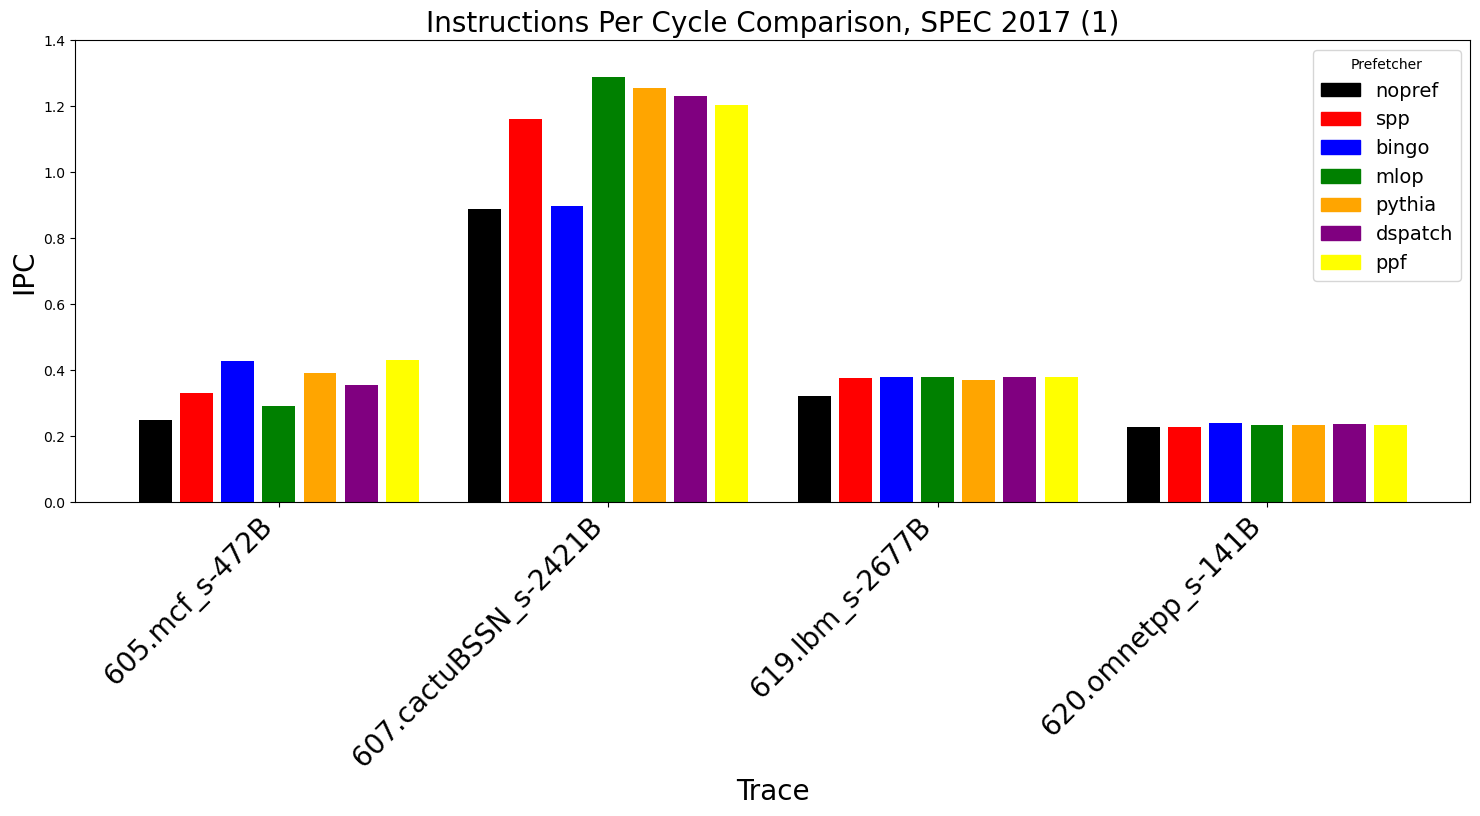

In [7]:
plot_ipc_bar(df=spec_df_1, title='Instructions Per Cycle Comparison, SPEC 2017 (1)')

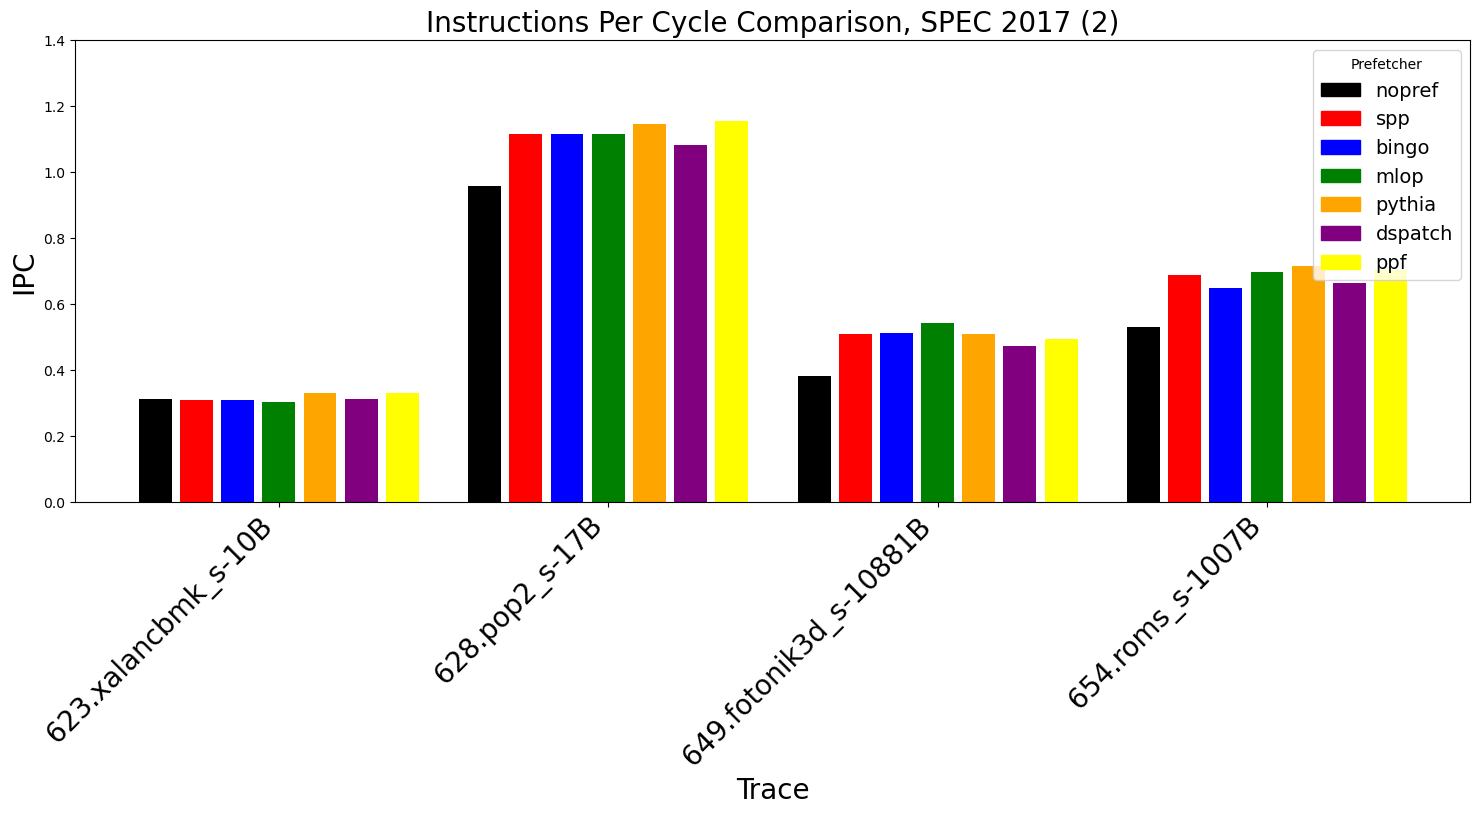

In [8]:
plot_ipc_bar(df=spec_df_2, title='Instructions Per Cycle Comparison, SPEC 2017 (2)')

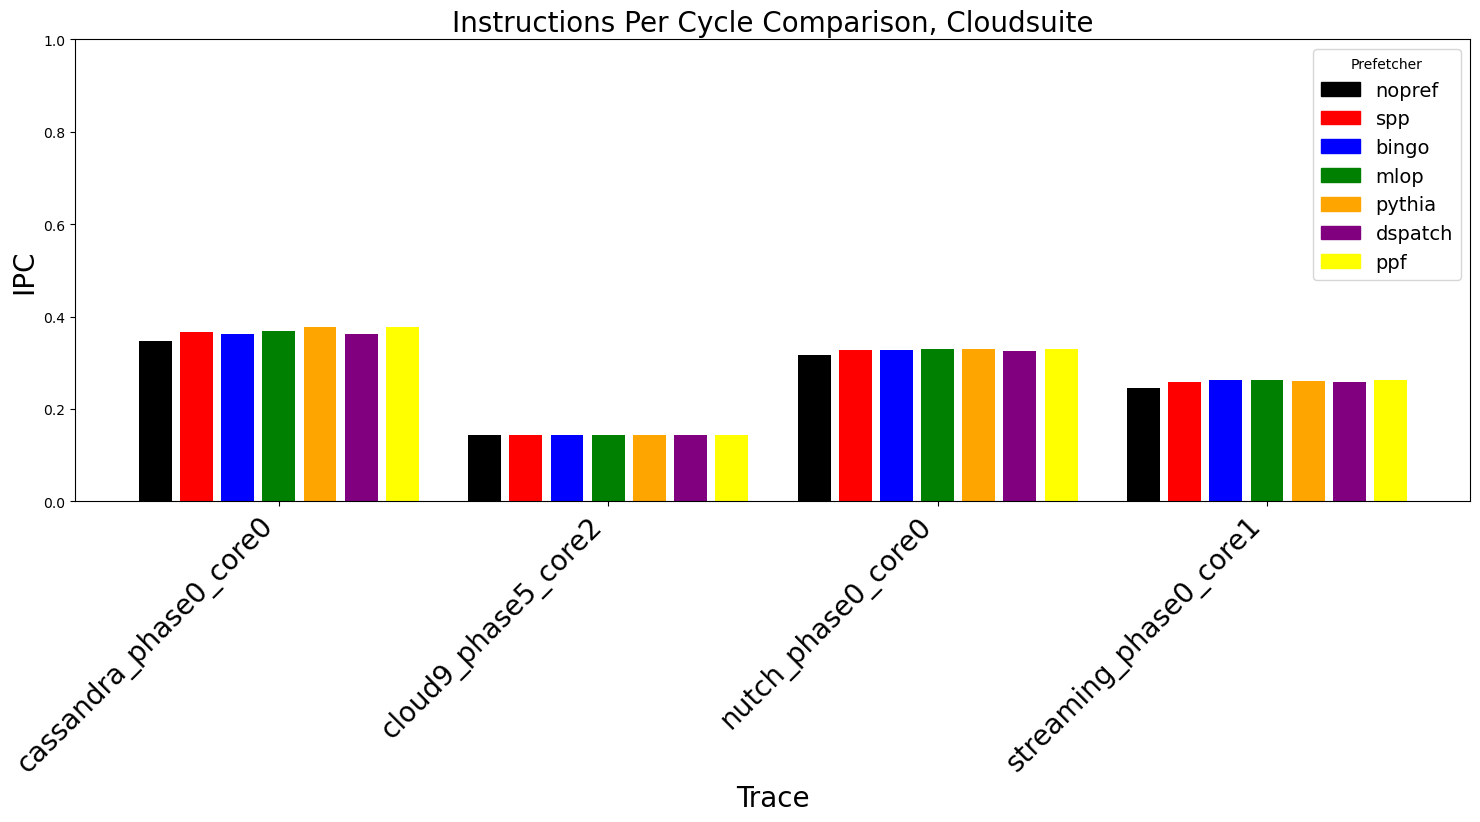

In [9]:
plot_ipc_bar(df=cloud_df, title='Instructions Per Cycle Comparison, Cloudsuite', y_max=1)

# Coverage

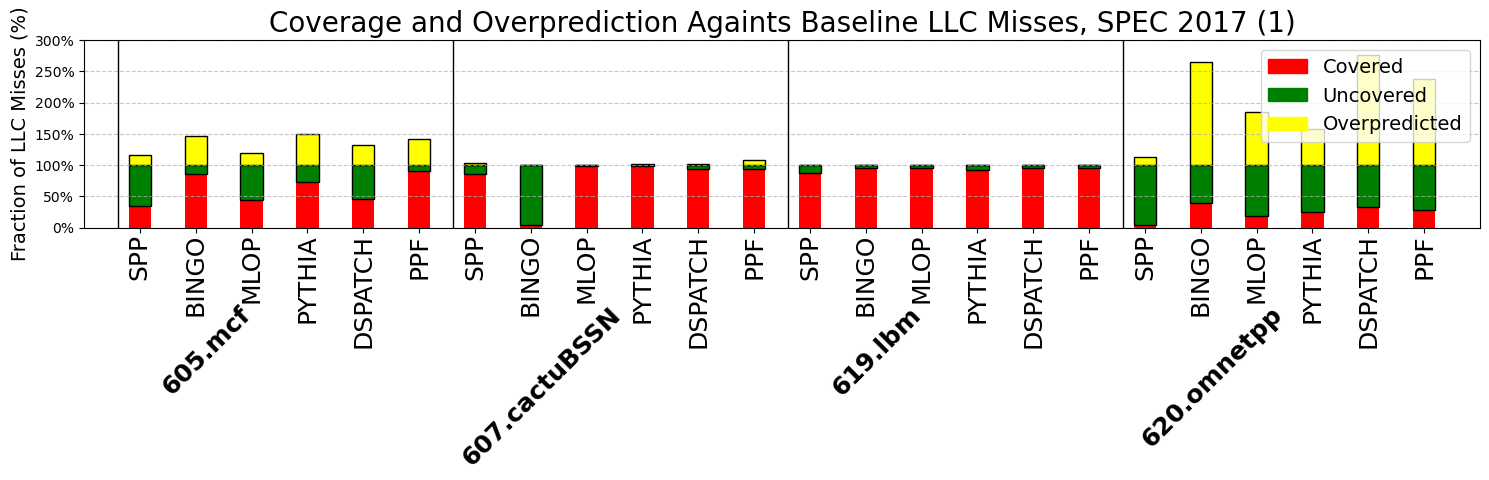

In [10]:
plot_coverage_bar(
    df=spec_df_1,
    title='Coverage and Overprediction Againts Baseline LLC Misses, SPEC 2017 (1)',
    xticks_top_size=18
)

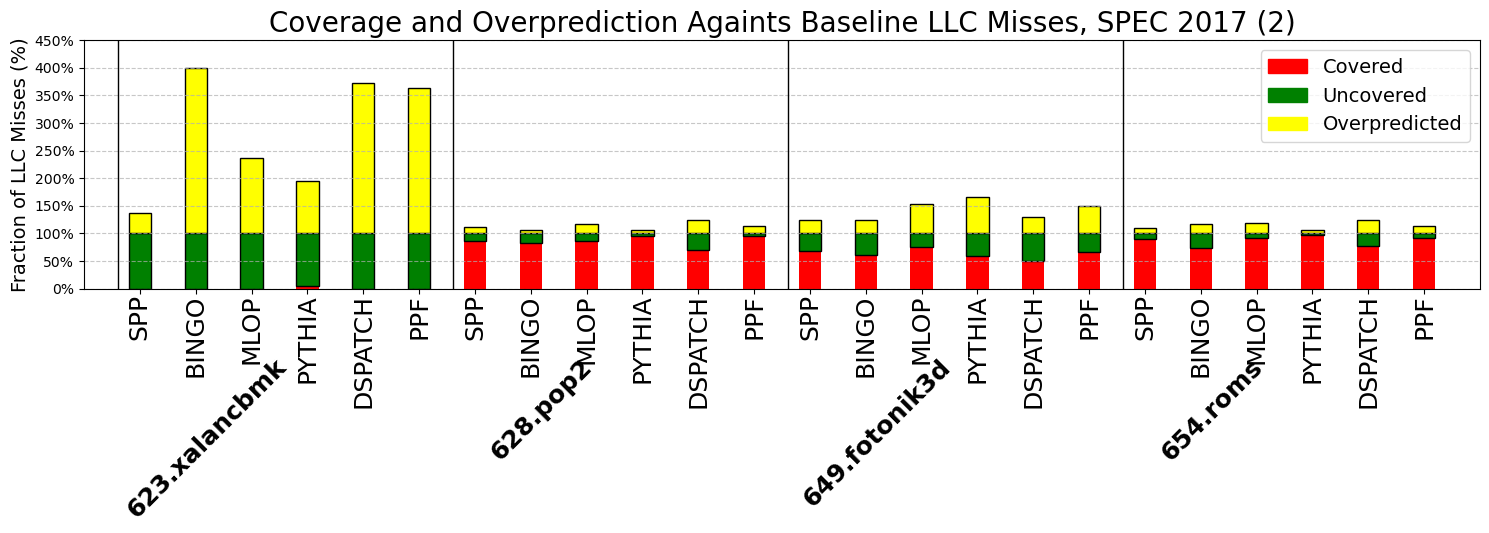

In [11]:
plot_coverage_bar(
    df=spec_df_2,
    title='Coverage and Overprediction Againts Baseline LLC Misses, SPEC 2017 (2)',
    xticks_top_size=18
)

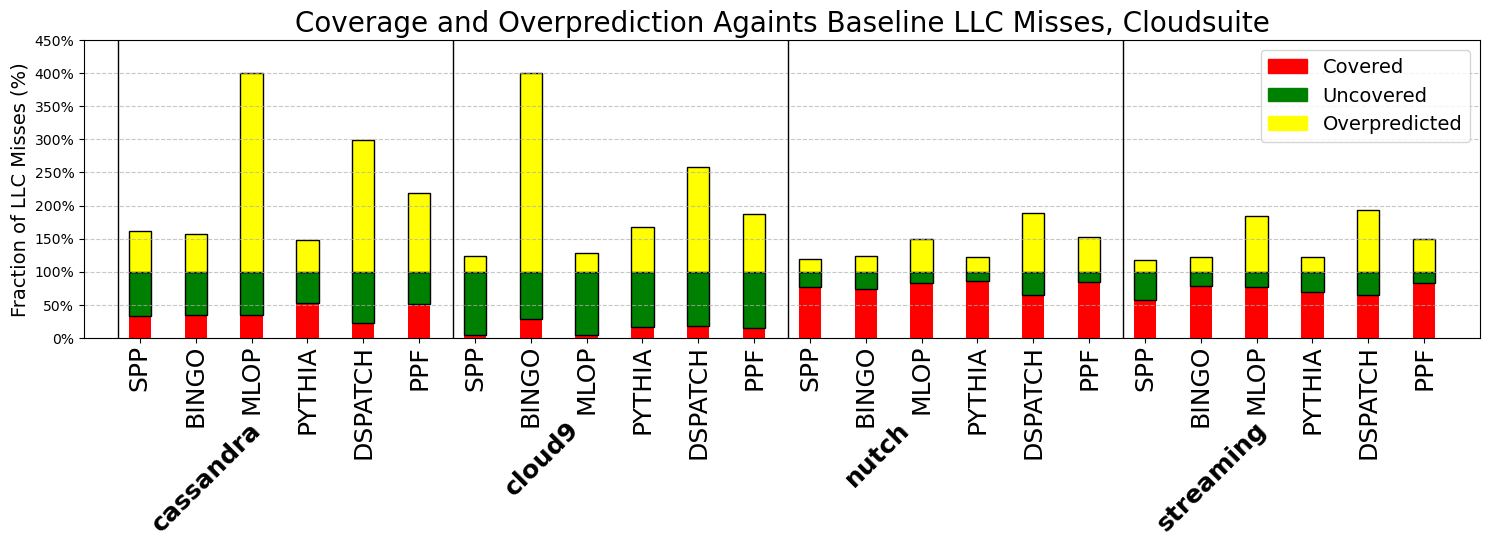

In [12]:
plot_coverage_bar(
    df=cloud_df,
    title='Coverage and Overprediction Againts Baseline LLC Misses, Cloudsuite',
    xticks_top_size=18
)

# Load Miss Rate

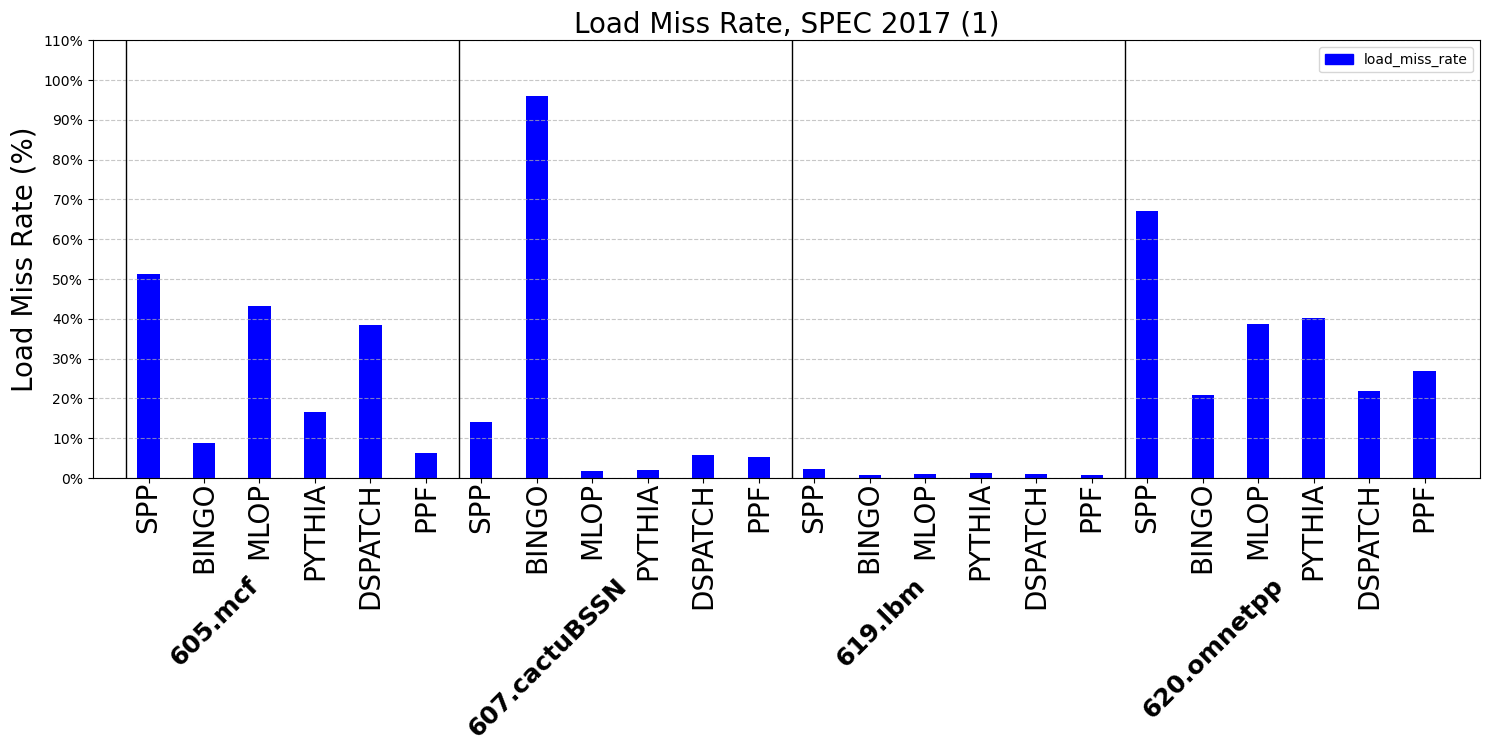

In [13]:
plot_bar(df=spec_df_1, stat_name= 'load_miss_rate', y_label='Load Miss Rate (%)', title='Load Miss Rate, SPEC 2017 (1)', color='blue')

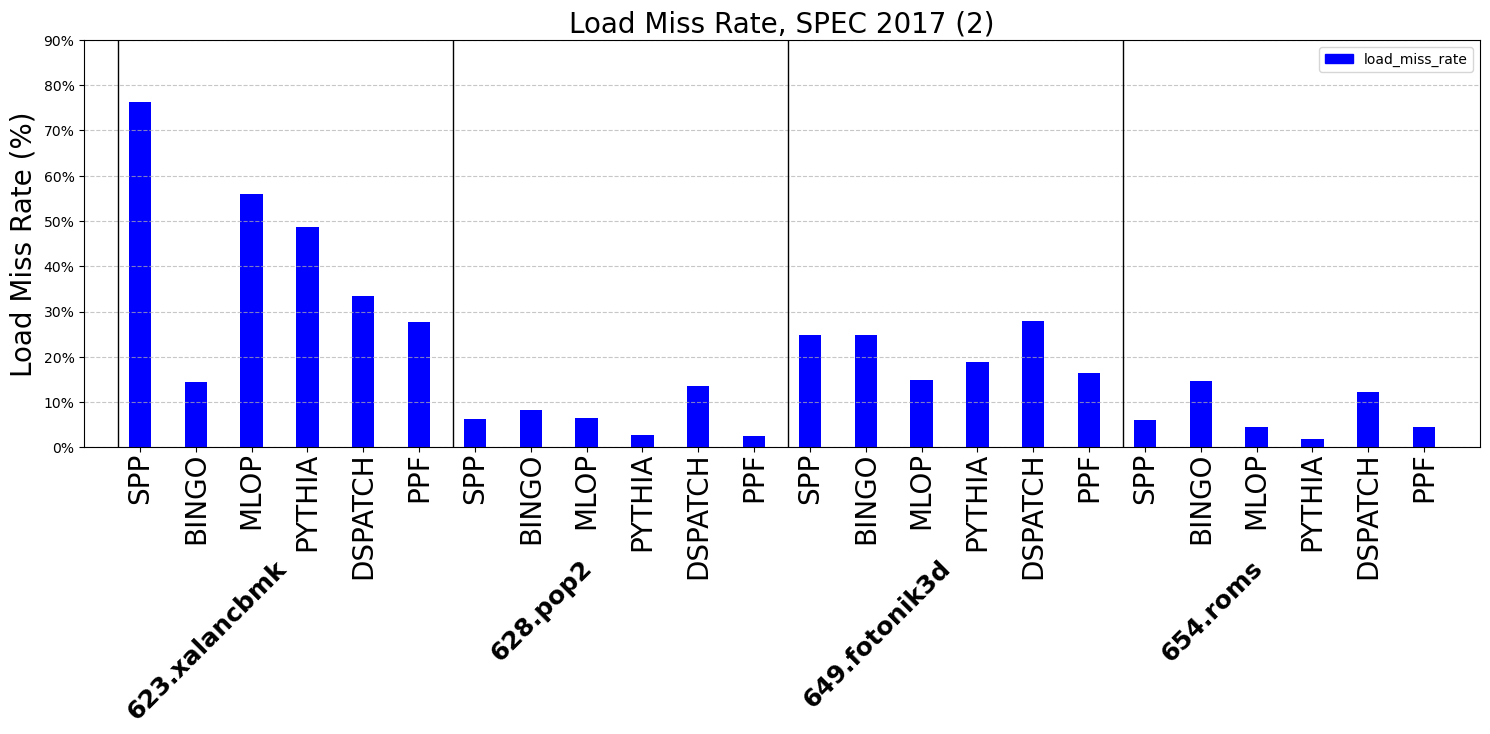

In [14]:
plot_bar(df=spec_df_2, stat_name= 'load_miss_rate', y_label='Load Miss Rate (%)', title='Load Miss Rate, SPEC 2017 (2)', color='blue')

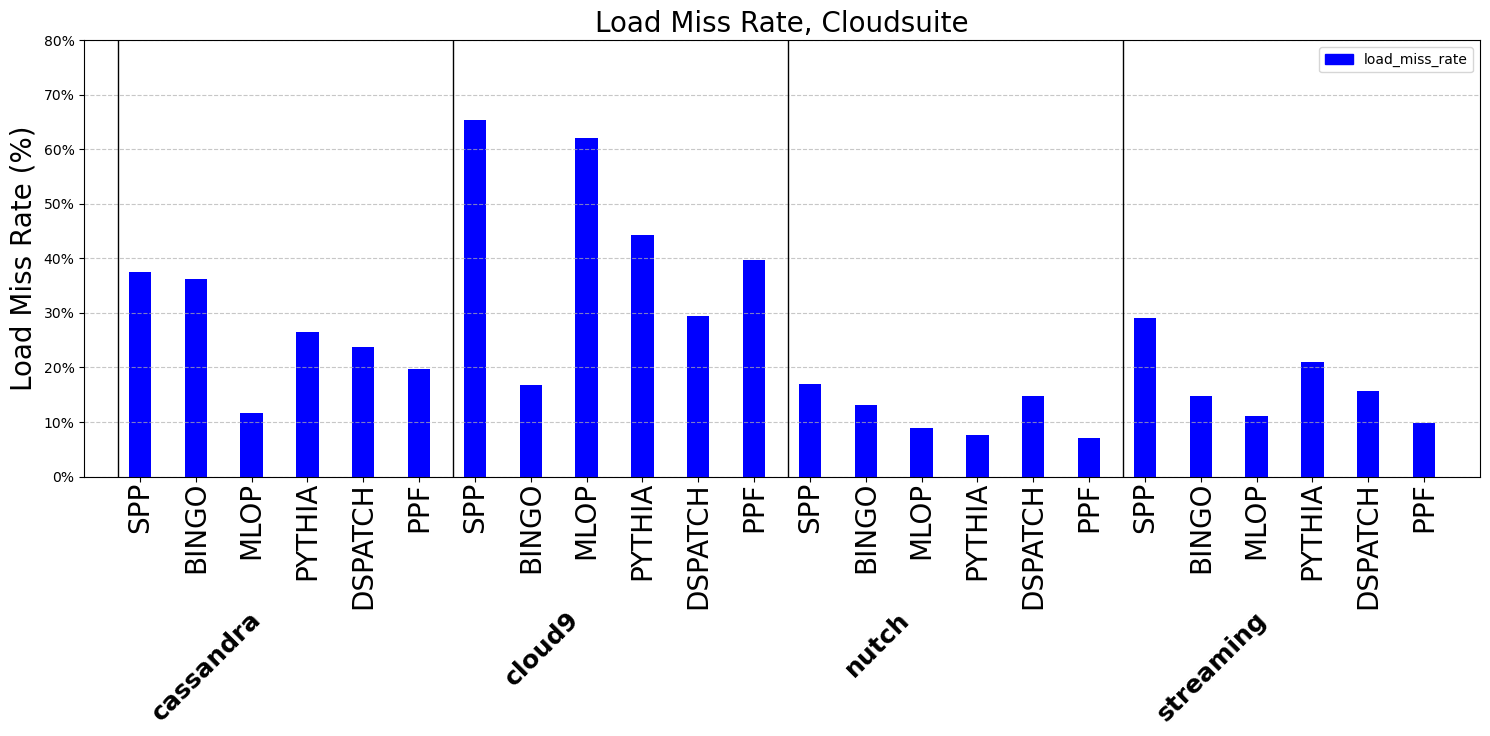

In [15]:
plot_bar(df=cloud_df, stat_name= 'load_miss_rate', y_label='Load Miss Rate (%)', title='Load Miss Rate, Cloudsuite', color='blue')

# RFO Miss Rate

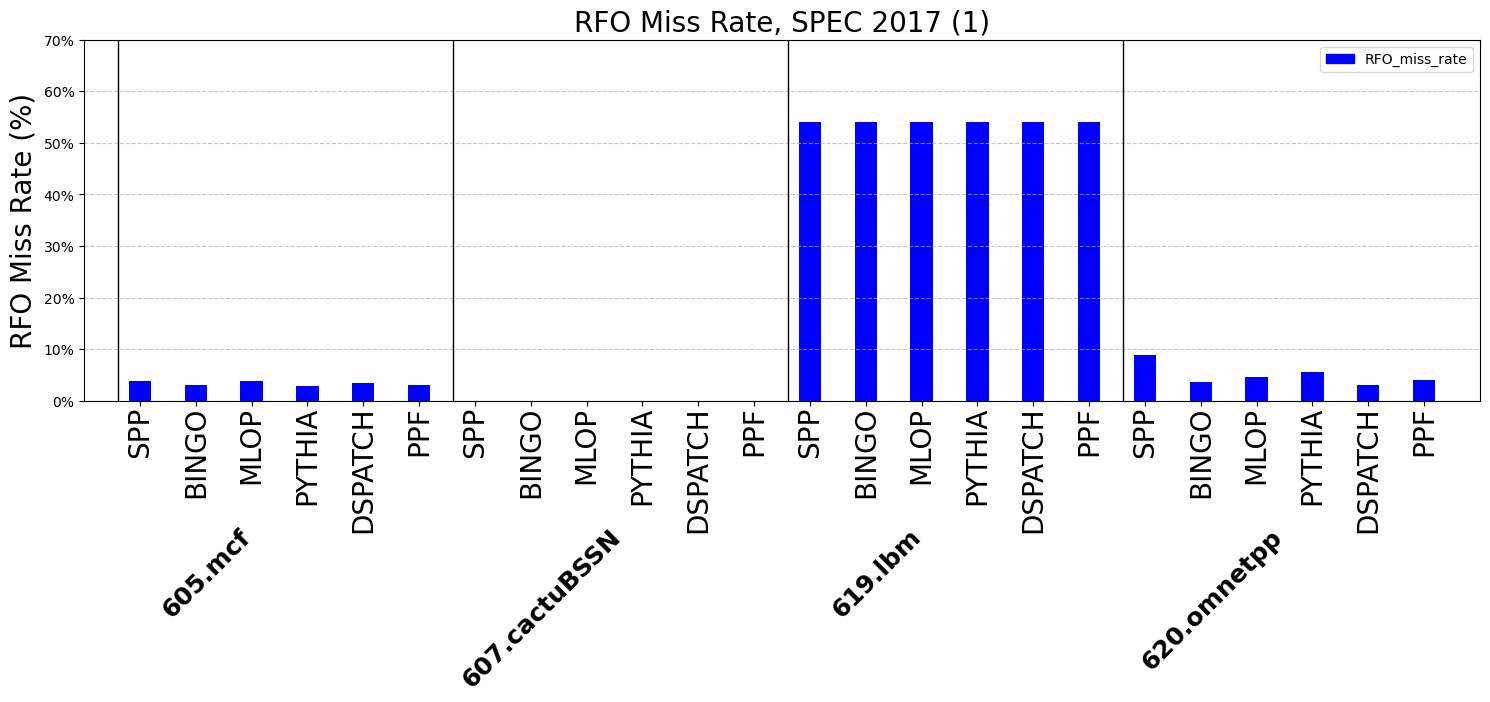

In [16]:
plot_bar(df=spec_df_1, stat_name= 'RFO_miss_rate', y_label='RFO Miss Rate (%)', title='RFO Miss Rate, SPEC 2017 (1)', color='blue')

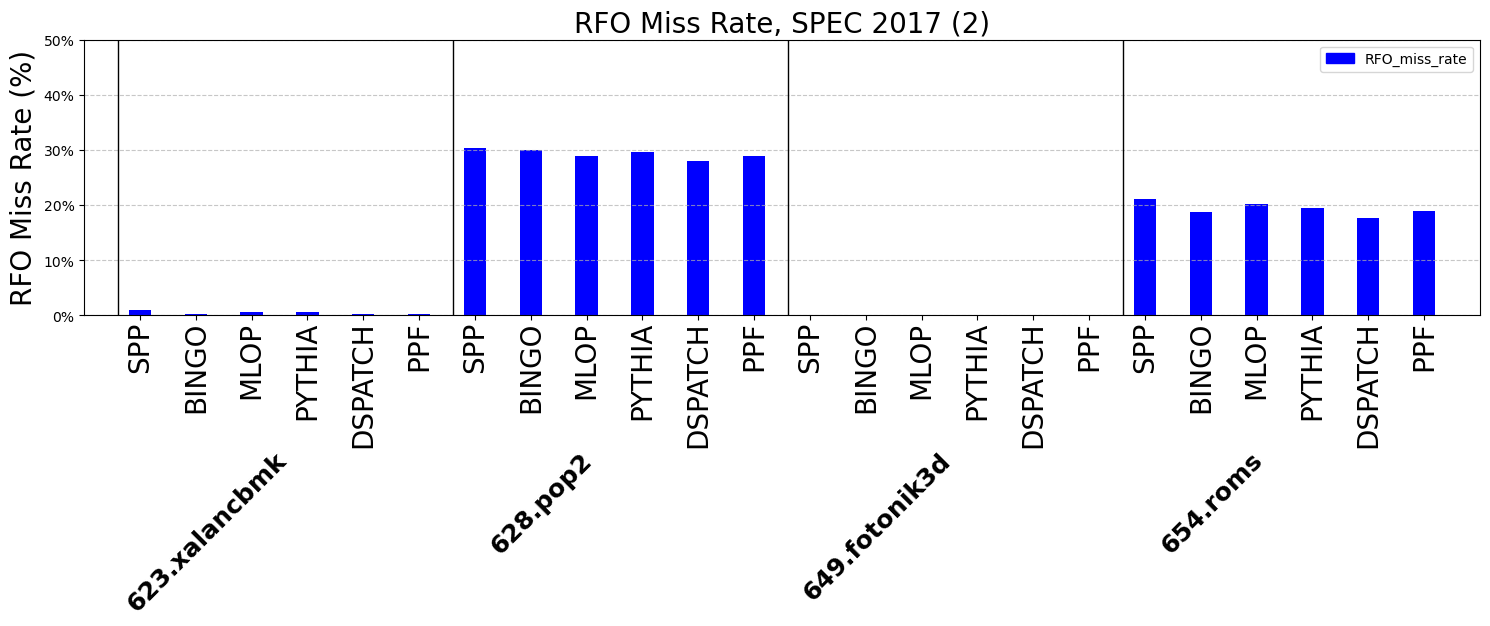

In [17]:
plot_bar(df=spec_df_2, stat_name= 'RFO_miss_rate', y_label='RFO Miss Rate (%)', title='RFO Miss Rate, SPEC 2017 (2)', color='blue')

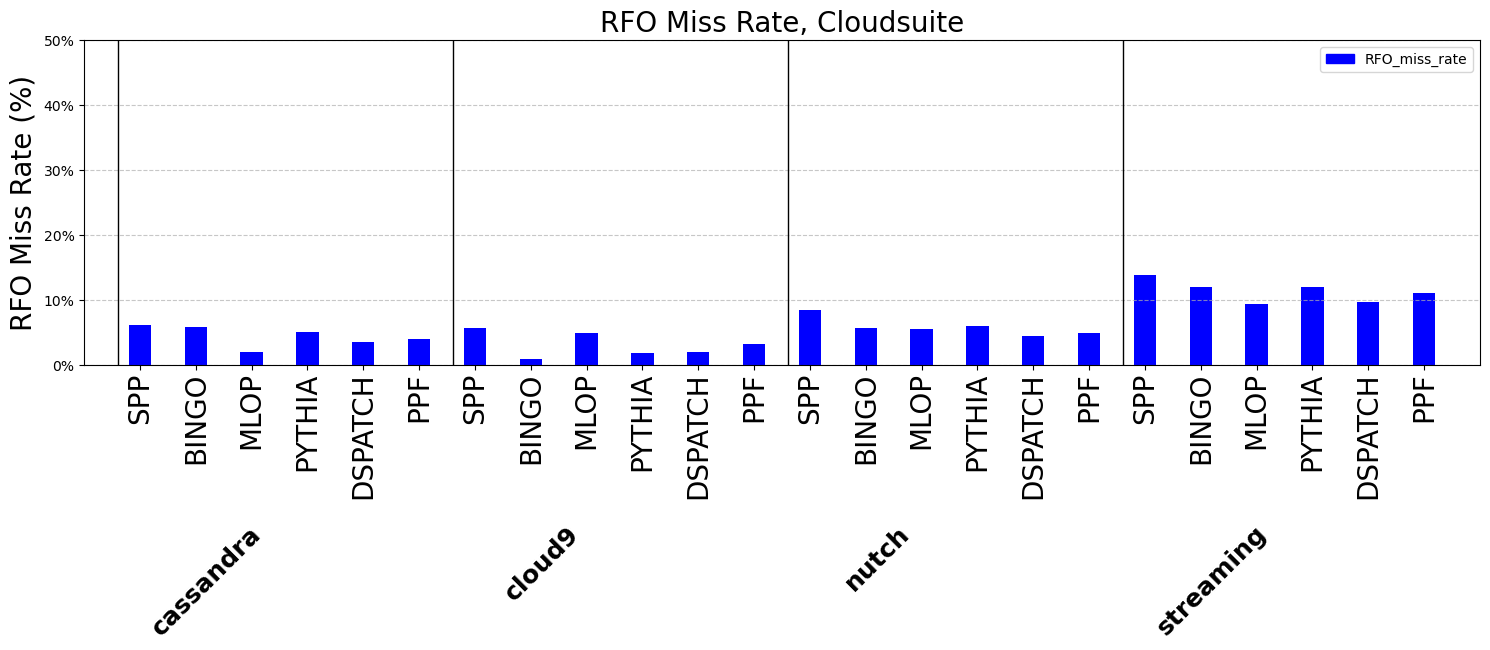

In [18]:
plot_bar(df=cloud_df, stat_name= 'RFO_miss_rate', y_label='RFO Miss Rate (%)', title='RFO Miss Rate, Cloudsuite', color='blue')

# Writeback Miss Rate

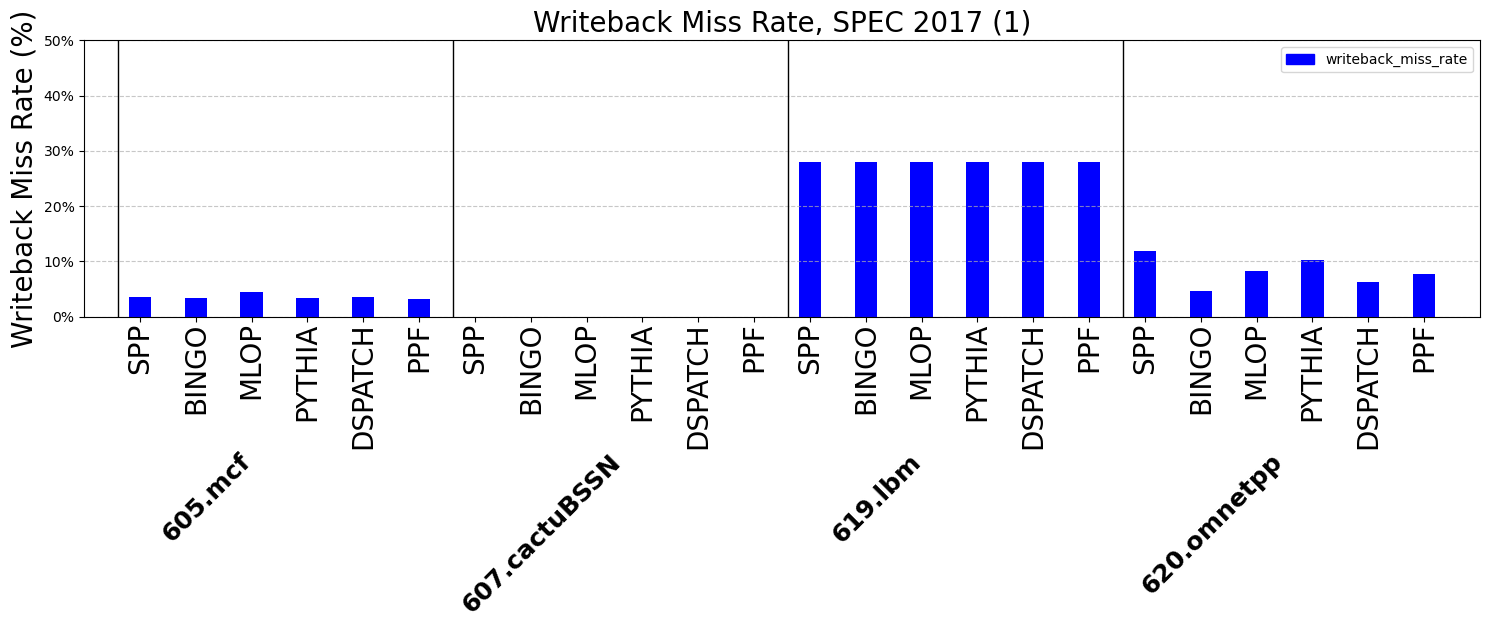

In [19]:
plot_bar(df=spec_df_1, stat_name= 'writeback_miss_rate', y_label='Writeback Miss Rate (%)', title='Writeback Miss Rate, SPEC 2017 (1)', color='blue')

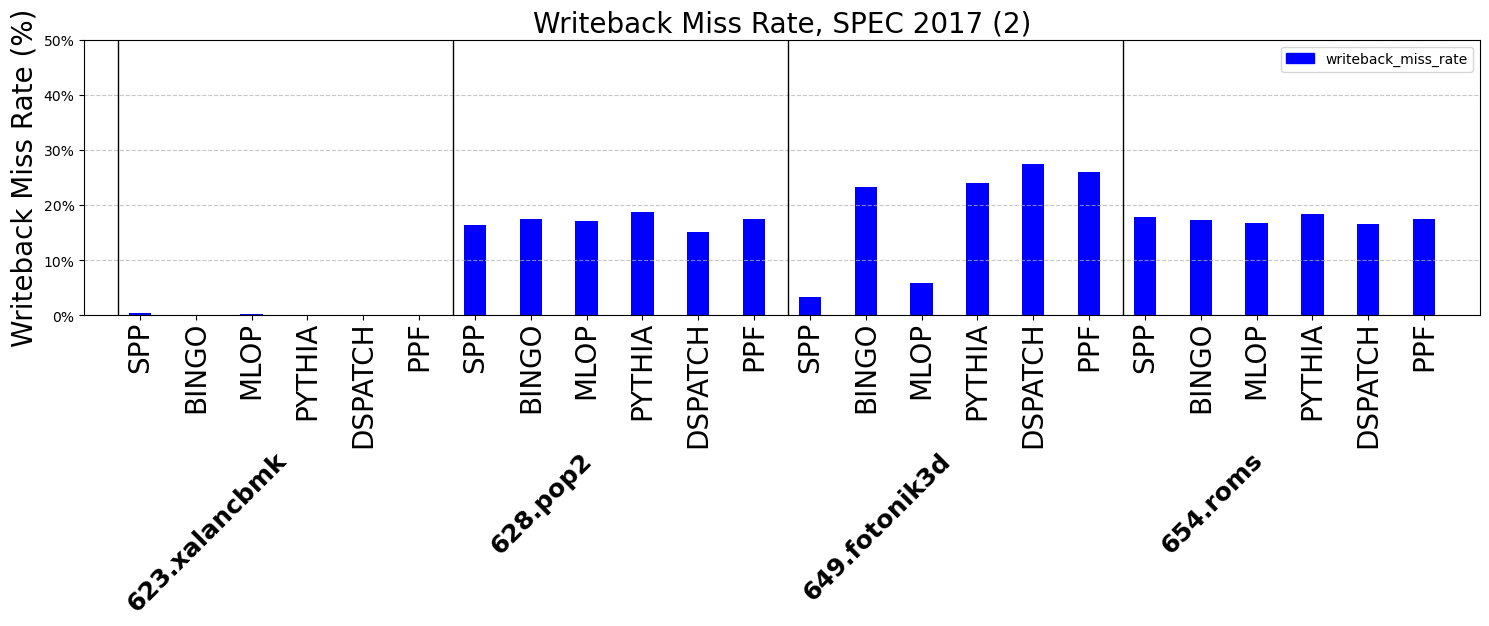

In [20]:
plot_bar(df=spec_df_2, stat_name= 'writeback_miss_rate', y_label='Writeback Miss Rate (%)', title='Writeback Miss Rate, SPEC 2017 (2)', color='blue')

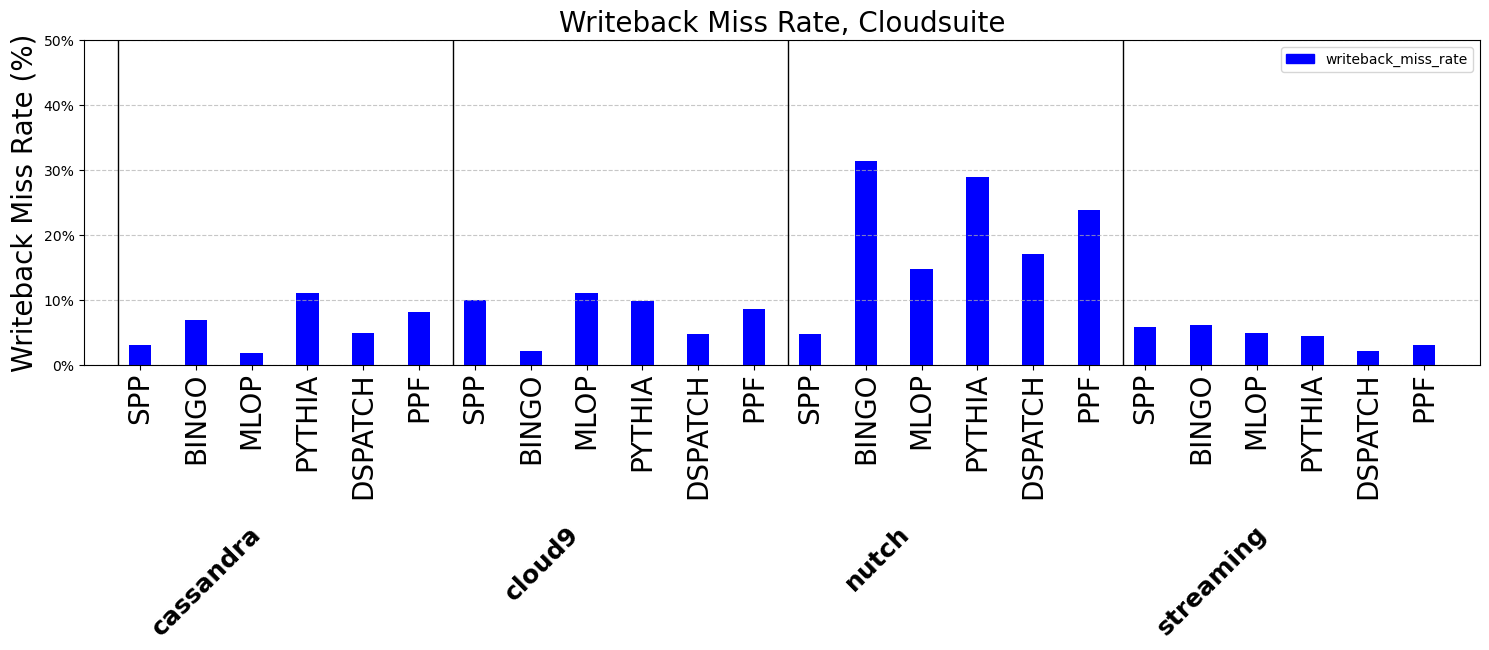

In [21]:
plot_bar(df=cloud_df, stat_name= 'writeback_miss_rate', y_label='Writeback Miss Rate (%)', title='Writeback Miss Rate, Cloudsuite', color='blue')

# IPC Improvement

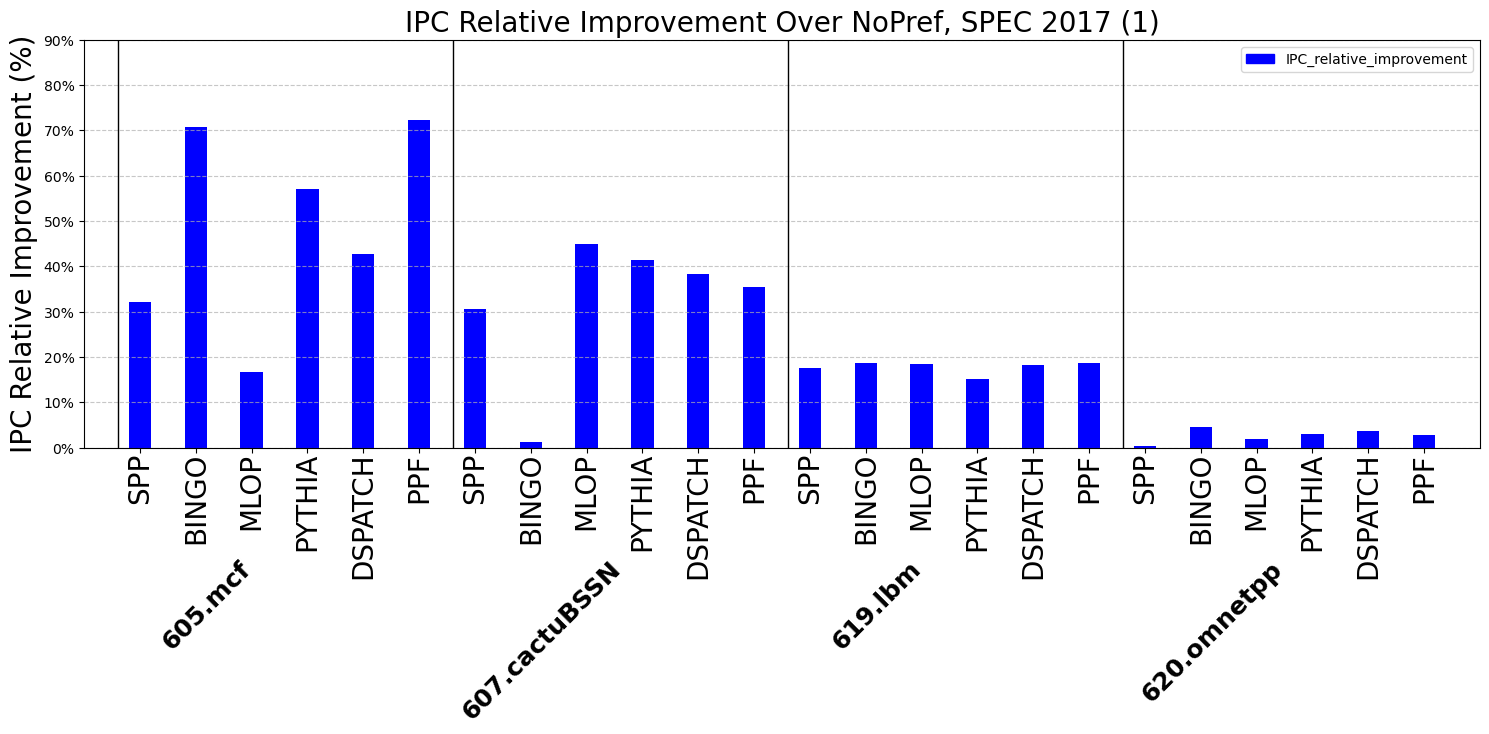

In [22]:
plot_bar(df=spec_df_1, stat_name= 'IPC_relative_improvement', y_label='IPC Relative Improvement (%)', title='IPC Relative Improvement Over NoPref, SPEC 2017 (1)', color='blue')

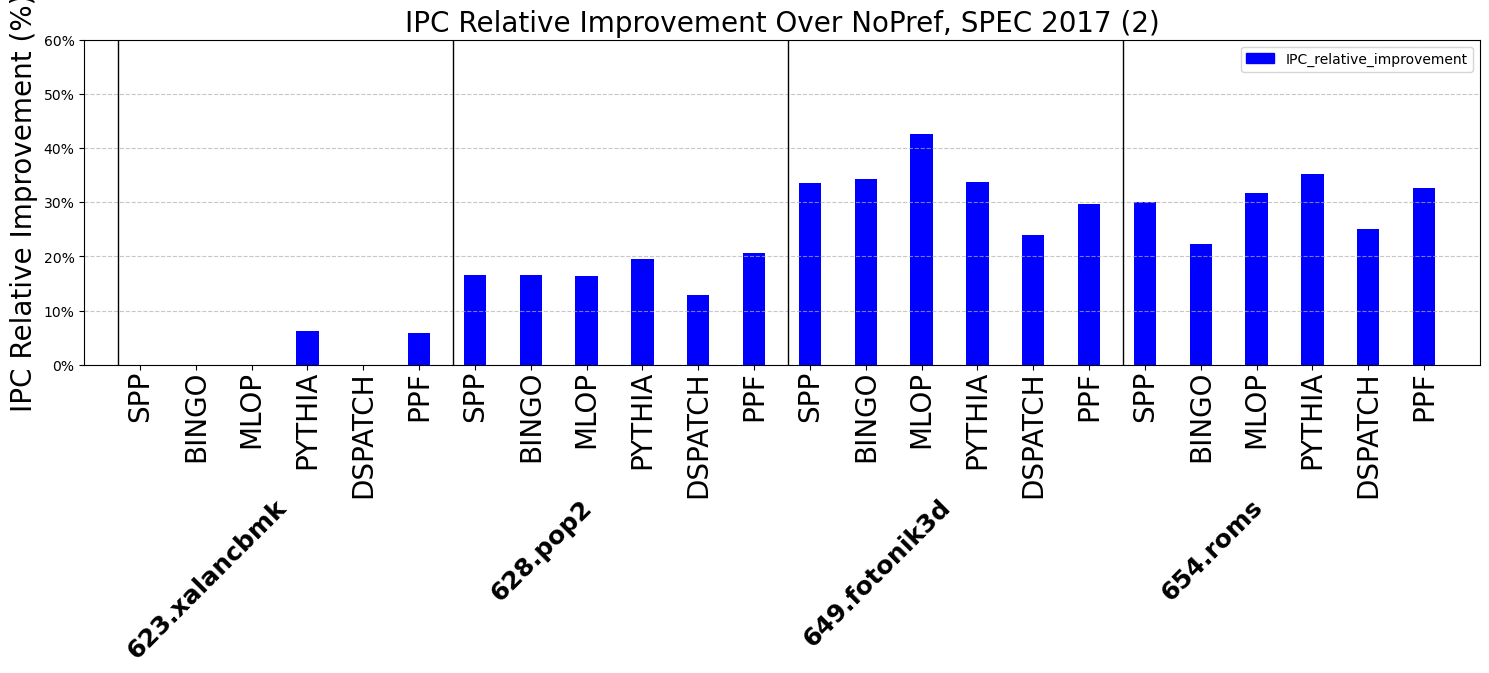

In [23]:
plot_bar(df=spec_df_2, stat_name= 'IPC_relative_improvement', y_label='IPC Relative Improvement (%)', title='IPC Relative Improvement Over NoPref, SPEC 2017 (2)', color='blue')

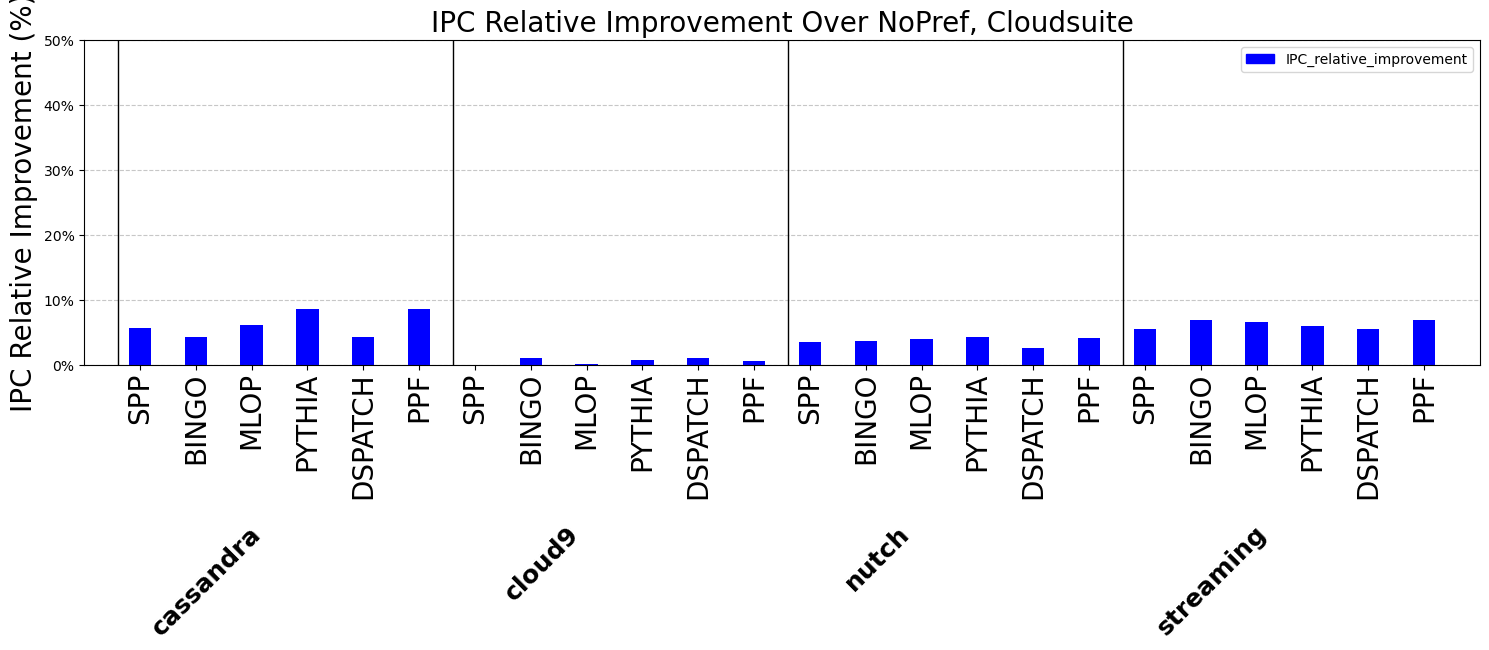

In [24]:
plot_bar(df=cloud_df, stat_name= 'IPC_relative_improvement', y_label='IPC Relative Improvement (%)', title='IPC Relative Improvement Over NoPref, Cloudsuite', color='blue')